In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install supervision==0.3.0
! pip install -q transformers
! pip install -q pytorch-lightning
! pip install torch
! pip install -q timm
! pip install scipy
! pip install Cython
!pip install -q coco_eval

In [ ]:
import os
import torch
import supervision
import transformers
import pytorch_lightning
import torch
import os
import torchvision
from transformers import DetrForObjectDetection, DetrImageProcessor

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.3 ; cuda:  cu121
; supervision: 0.3.0 ; transformers: 4.42.4 ; pytorch_lightning: 2.3.3


In [ ]:
CHECKPOINT = 'facebook/detr-resnet-50'
image_processor = DetrImageProcessor.from_pretrained(CHECKPOINT)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


### Data Loaders

In [ ]:
# settings
ANNOTATION_FILE_NAME = r"result.json"
TRAIN_DIRECTORY = os.path.join(r"/content/drive/MyDrive/DocSearch/DETR FINAL DATA/", r"train")
VAL_DIRECTORY = os.path.join(r"/content/drive/MyDrive/DocSearch/DETR FINAL DATA/", r"val")
TEST_DIRECTORY = os.path.join(r"/content/drive/MyDrive/DocSearch/DETR FINAL DATA/", r"test")

class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(
        self,
        image_directory_path: str,
        image_processor,
        train: bool = True
    ):
        annotation_file_path = os.path.join(image_directory_path, ANNOTATION_FILE_NAME)
        super(CocoDetection, self).__init__(image_directory_path, annotation_file_path)
        self.image_processor = image_processor

    def __getitem__(self, idx):
        images, annotations = super(CocoDetection, self).__getitem__(idx)
        image_id = self.ids[idx]
        annotations = {'image_id': image_id, 'annotations': annotations}
        encoding = self.image_processor(images=images, annotations=annotations, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()
        target = encoding["labels"][0]

        return pixel_values, target

In [ ]:
TRAIN_DATASET = CocoDetection(
    image_directory_path=TRAIN_DIRECTORY,
    image_processor=image_processor,
    train=True)
VAL_DATASET = CocoDetection(
    image_directory_path=VAL_DIRECTORY,
    image_processor=image_processor,
    train=False)
TEST_DATASET = CocoDetection(
    image_directory_path=TEST_DIRECTORY,
    image_processor=image_processor,
    train=False)

print("Number of training examples:", len(TRAIN_DATASET))
print("Number of validation examples:", len(VAL_DATASET))
print("Number of test examples:", len(TEST_DATASET))

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Number of training examples: 145
Number of validation examples: 32
Number of test examples: 19


### Visualizations

In [ ]:

categories = VAL_DATASET.coco.cats
id2label = {k: v['name'] for k,v in categories.items()}
id2label

{0: 'bar-scale', 1: 'color-stamp', 2: 'detail-labels', 3: 'north-sign'}

Image #143
/content/drive/MyDrive/DocSearch/DETR FINAL DATA/train/images/9636cbc8-output_folder144.png


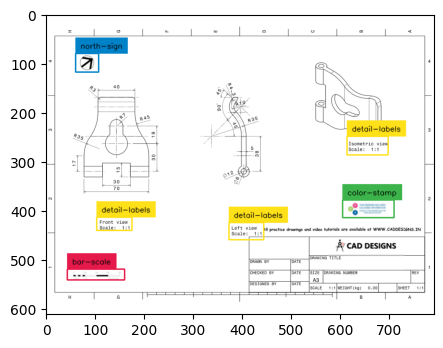

In [ ]:
import random
import cv2
import numpy as np
import torch
import supervision as sv

image_ids = TRAIN_DATASET.coco.getImgIds()
image_id = random.choice(image_ids)
print('Image #{}'.format(image_id))

image = TRAIN_DATASET.coco.loadImgs(image_id)[0]
annotations = TRAIN_DATASET.coco.imgToAnns[image_id]
image_path = os.path.join(TRAIN_DATASET.root,image['file_name'])
print(image_path)
image = cv2.imread(image_path)

# annotate
detections = sv.Detections.from_coco_annotations(coco_annotation=annotations)

categories = TRAIN_DATASET.coco.cats
id2label = {k: v['name'] for k,v in categories.items()}

labels = [
    f"{id2label[class_id]}"
    for _, _, class_id, _
    in detections
]

box_annotator = sv.BoxAnnotator()
frame = box_annotator.annotate(scene=image, detections=detections, labels=labels)

%matplotlib inline
sv.show_frame_in_notebook(image, (5, 5))

In [ ]:
id2label

{0: 'bar-scale', 1: 'color-stamp', 2: 'detail-labels', 3: 'north-sign'}

### Dataloaders

In [ ]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    # DETR authors employ various image sizes during training, making it not possible
    # to directly batch together images. Hence they pad the images to the biggest
    # resolution in a given batch, and create a corresponding binary pixel_mask
    # which indicates which pixels are real/which are padding
    pixel_values = [item[0] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item[1] for item in batch]
    return {
        'pixel_values': encoding['pixel_values'],
        'pixel_mask': encoding['pixel_mask'],
        'labels': labels
    }

TRAIN_DATALOADER = DataLoader(dataset=TRAIN_DATASET, collate_fn=collate_fn, batch_size=8, shuffle=True)
VAL_DATALOADER = DataLoader(dataset=VAL_DATASET, collate_fn=collate_fn, batch_size=4)
TEST_DATALOADER = DataLoader(dataset=TEST_DATASET, collate_fn=collate_fn, batch_size=4)

### Model Training

## Model 1

In [ ]:
import pytorch_lightning as pl
from transformers import DetrForObjectDetection
import torch
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torchmetrics import Accuracy, Precision, Recall

class Detr(pl.LightningModule):
    def __init__(self, lr, lr_backbone, weight_decay):
        super().__init__()
        self.model = DetrForObjectDetection.from_pretrained(
            pretrained_model_name_or_path=CHECKPOINT,
            num_labels=len(id2label),
            # num_labels=len(id2label)+1,
            ignore_mismatched_sizes=True
        )

        self.lr = lr
        self.lr_backbone = lr_backbone
        self.weight_decay = weight_decay

    def forward(self, pixel_values, pixel_mask):
        return self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    def common_step(self, batch, batch_idx, mode='train'):
        pixel_values = batch["pixel_values"]
        pixel_mask = batch.get("pixel_mask", None)
        labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

        outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

        loss = outputs.loss
        loss_dict = outputs.loss_dict

        # Logging batch-specific information


        self.log(f'{mode}_loss', loss, on_step=False, on_epoch=True, prog_bar=True)

        if mode == 'val':
            self.log('val_loss_ce', loss_dict['loss_ce'].item(), on_step=False, on_epoch=True, prog_bar=True)
            self.log('val_loss_bbox', loss_dict['loss_bbox'].item(), on_step=False, on_epoch=True, prog_bar=True)

        for k, v in loss_dict.items():
            self.log(f'{mode}_{k}', v.item(), on_step=False, on_epoch=True, prog_bar=True)

        return loss

    def training_step(self, batch, batch_idx):
        return self.common_step(batch, batch_idx, mode='train')

    def validation_step(self, batch, batch_idx):
        return self.common_step(batch, batch_idx, mode='val')

    def configure_optimizers(self):
        param_dicts = [
            {"params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
            {
                "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                "lr": self.lr_backbone,
            },
        ]
        optimizer = torch.optim.AdamW(param_dicts, lr=self.lr, weight_decay=self.weight_decay)
        return optimizer

    def train_dataloader(self):
        return TRAIN_DATALOADER

    def val_dataloader(self):
        return TEST_DATALOADER



In [ ]:
from pytorch_lightning.callbacks import ModelCheckpoint

model = Detr(lr=5e-5, lr_backbone=5e-5, weight_decay=1e-4)

checkpoint_callback = ModelCheckpoint(
    dirpath=r'/content/drive/MyDrive/DETR /DETR 11 ',
    filename='detr-{epoch:02d}-{val_loss:.2f}',
    save_top_k=-1,
    every_n_epochs=10,
    save_last=True
)

batch = next(iter(TRAIN_DATALOADER))
outputs = model(pixel_values=batch['pixel_values'], pixel_mask=batch['pixel_mask'])

outputs.logits.shape

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

torch.Size([8, 100, 5])

In [ ]:
print(type(outputs))
print(dir(outputs))

<class 'transformers.models.detr.modeling_detr.DetrObjectDetectionOutput'>
['__annotations__', '__class__', '__class_getitem__', '__contains__', '__dataclass_fields__', '__dataclass_params__', '__delattr__', '__delitem__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__ior__', '__iter__', '__le__', '__len__', '__lt__', '__match_args__', '__module__', '__ne__', '__new__', '__or__', '__post_init__', '__reduce__', '__reduce_ex__', '__repr__', '__reversed__', '__ror__', '__setattr__', '__setitem__', '__sizeof__', '__str__', '__subclasshook__', 'auxiliary_outputs', 'clear', 'copy', 'cross_attentions', 'decoder_attentions', 'decoder_hidden_states', 'encoder_attentions', 'encoder_hidden_states', 'encoder_last_hidden_state', 'fromkeys', 'get', 'items', 'keys', 'last_hidden_state', 'logits', 'loss', 'loss_dict', 'move_to_end', 'pop', 'popitem', 'pred_boxes', 'setdefault', 'to_tuple'

In [ ]:
from pytorch_lightning import Trainer

MAX_EPOCHS = 100

trainer = Trainer(devices=1,
                  accelerator="gpu",
                  max_epochs=MAX_EPOCHS,
                  gradient_clip_val=0.1,
                  accumulate_grad_batches=8,
                  log_every_n_steps=5,
                  callbacks=checkpoint_callback)

trainer.fit(model, TRAIN_DATALOADER, VAL_DATALOADER)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                   | Params | Mode
--------------------------------------------------------
0 | model | DetrForObjectDetection | 41.5 M | eval
--------------------------------------------------------
41.3 M    Trainable params
222 K     Non-trainable params
41.5 M    Total params
166.010   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 4. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 8. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


In [ ]:
model.parameters

<bound method Module.parameters of Detr(
  (model): DetrForObjectDetection(
    (model): DetrModel(
      (backbone): DetrConvModel(
        (conv_encoder): DetrConvEncoder(
          (model): FeatureListNet(
            (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
            (bn1): DetrFrozenBatchNorm2d()
            (act1): ReLU(inplace=True)
            (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
            (layer1): Sequential(
              (0): Bottleneck(
                (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (bn1): DetrFrozenBatchNorm2d()
                (act1): ReLU(inplace=True)
                (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (bn2): DetrFrozenBatchNorm2d()
                (drop_block): Identity()
                (act2): ReLU(inplace=True)
                (aa): Identity()
                (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (bn3): DetrFrozenBatchNorm2d()
                (act3): ReLU(inplace=True)
                (downsample): Sequential(
                  (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                  (1): DetrFrozenBatchNorm2d()
                )
              )
              (1): Bottleneck(
                (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (bn1): DetrFrozenBatchNorm2d()
                (act1): ReLU(inplace=True)
                (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (bn2): DetrFrozenBatchNorm2d()
                (drop_block): Identity()
                (act2): ReLU(inplace=True)
                (aa): Identity()
                (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (bn3): DetrFrozenBatchNorm2d()
                (act3): ReLU(inplace=True)
              )
              (2): Bottleneck(
                (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (bn1): DetrFrozenBatchNorm2d()
                (act1): ReLU(inplace=True)
                (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (bn2): DetrFrozenBatchNorm2d()
                (drop_block): Identity()
                (act2): ReLU(inplace=True)
                (aa): Identity()
                (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (bn3): DetrFrozenBatchNorm2d()
                (act3): ReLU(inplace=True)
              )
            )
            (layer2): Sequential(
              (0): Bottleneck(
                (conv1): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (bn1): DetrFrozenBatchNorm2d()
                (act1): ReLU(inplace=True)
                (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
                (bn2): DetrFrozenBatchNorm2d()
                (drop_block): Identity()
                (act2): ReLU(inplace=True)
                (aa): Identity()
                (conv3): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (bn3): DetrFrozenBatchNorm2d()
                (act3): ReLU(inplace=True)
                (downsample): Sequential(
                  (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
                  (1): DetrFrozenBatchNorm2d()
                )
              )
              (1): Bottleneck(
                (conv1): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (bn1): DetrFrozenBatchNorm2d()
                (act1): ReLU(inplace=True)
                (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (bn2): DetrFrozenBatchNorm2d()

In [ ]:
trainer.validate(model)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 3. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   val_cardinality_error   │    0.31578946113586426    │
│         val_loss          │    0.7580862641334534     │
│       val_loss_bbox       │    0.02130609191954136    │
│        val_loss_ce        │    0.13657858967781067    │
│       val_loss_giou       │    0.25748857855796814    │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.7580862641334534,
  'val_loss_ce': 0.13657858967781067,
  'val_loss_bbox': 0.02130609191954136,
  'val_loss_giou': 0.25748857855796814,
  'val_cardinality_error': 0.31578946113586426}]

### Save Model

In [ ]:
import torch
from transformers import DetrForObjectDetection, DetrImageProcessor

DRIVE = '/content/drive/MyDrive/DETR /DETR 11 '

# MODEL_PATH = os.path.join(HOME, 'custom-model')
# MODEL_PATH = os.path.join(DRIVE, 'DETR 10')
MODEL_PATH = DRIVE

# To Save
model.model.save_pretrained(MODEL_PATH)

### Load Model


In [ ]:
# # To Load
saved_model  = r'/content/drive/MyDrive/DETR /DETR 11 '
model = DetrForObjectDetection.from_pretrained(saved_model)

In [ ]:
TEST_DATASET

Dataset CocoDetection
    Number of datapoints: 19
    Root location: /content/drive/MyDrive/DocSearch/DETR FINAL DATA/test

In [ ]:
import random
import cv2
import supervision as sv

def ground_truth(DATASET):
    # Displays random images from the selected dataset
    CONFIDENCE_THRESHOLD = 0.7
    categories = DATASET.coco.cats
    id2label = {category['id']: category['name'] for category in categories.values()}
    box_annotator = supervision.BoxAnnotator()
    image_ids = DATASET.coco.getImgIds()
    image_id = random.choice(image_ids)
    print("Selected Image ID:", image_id)


    image  = DATASET.coco.loadImgs(image_id)[0]
    annotations = DATASET.coco.imgToAnns[image_id]
    image_path = os.path.join(DATASET.root, image['file_name'])
    image = cv2.imread(image_path)

    detections = supervision.Detections.from_coco_annotations(coco_annotation=annotations)
    labels = [f"{id2label[class_id]}" for _, _, class_id, _ in detections]
    frame_ground_truth = box_annotator.annotate(image, detections, labels=labels)

    %matplotlib inline
    sv.show_frame_in_notebook(frame_ground_truth, (8, 8))

Selected Image ID: 6


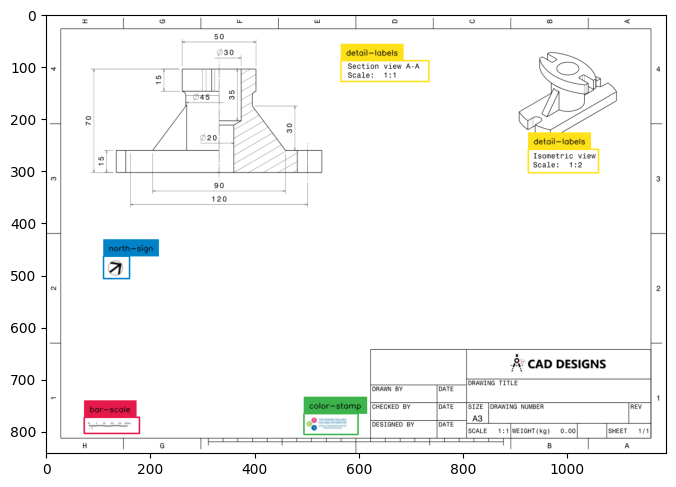

In [ ]:
ground_truth(DATASET=TEST_DATASET)

In [ ]:
CONFIDENCE_THRESHOLD = 0.5
categories = TEST_DATASET.coco.cats
id2label = {category['id']: category['name'] for category in categories.values()}
box_annotator = supervision.BoxAnnotator()
image_ids = TEST_DATASET.coco.getImgIds()


def predict(TEST_DATASET, image_id):
    print("Selected Image ID - ", image_id)
    image  = TEST_DATASET.coco.loadImgs(image_id)[0]
    annotations = TEST_DATASET.coco.imgToAnns[image_id]
    image_path = os.path.join(TEST_DATASET.root, image['file_name'])
    image = cv2.imread(image_path)

    with torch.no_grad():

        # load image and predict
        inputs = image_processor(images=image, return_tensors='pt')
        outputs = model(**inputs)

        # post-process
        target_sizes = torch.tensor([image.shape[:2]])
        results = image_processor.post_process_object_detection(
            outputs=outputs,
            threshold=CONFIDENCE_THRESHOLD,
            target_sizes=target_sizes
        )[0]

    # annotate
    detections = sv.Detections.from_transformers(transformers_results=results)
    labels = [f"{id2label[class_id]} {confidence:.2f}" for _, confidence, class_id, _ in detections]
    frame_detection = box_annotator.annotate(scene=image, detections=detections, labels=labels)

    %matplotlib inline
    sv.show_frame_in_notebook(frame_detection, (5, 5))
    return results


Selected Image ID -  0


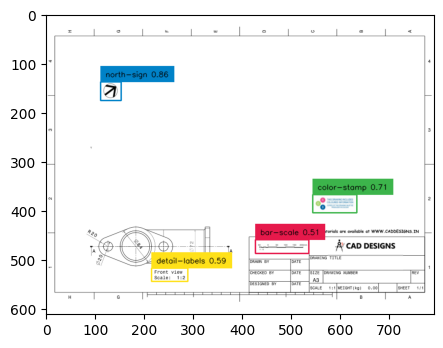

Selected Image ID -  1


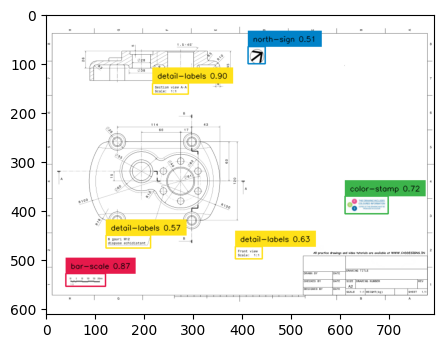

Selected Image ID -  2


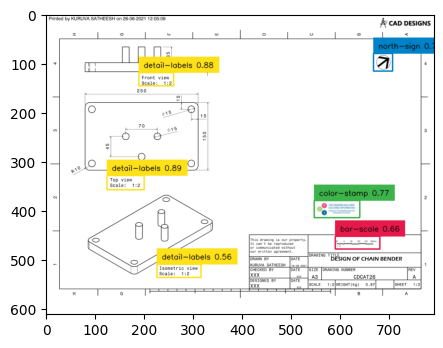

Selected Image ID -  3


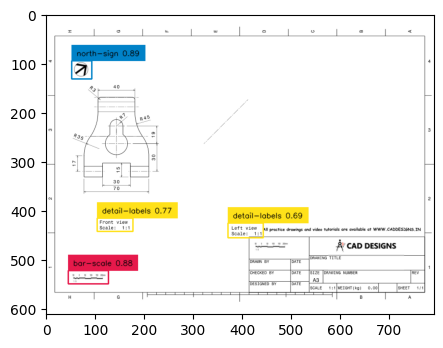

Selected Image ID -  4


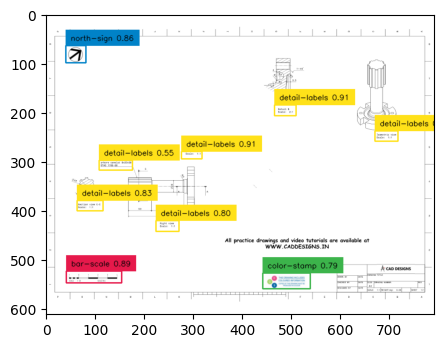

Selected Image ID -  5


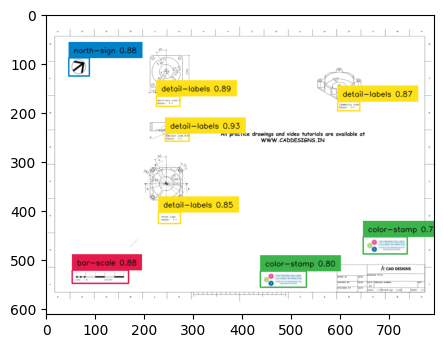

Selected Image ID -  6


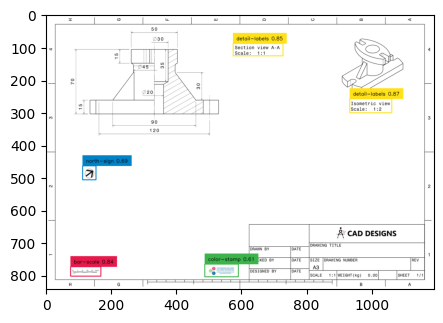

Selected Image ID -  7


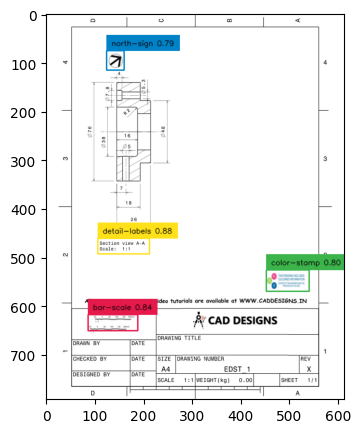

Selected Image ID -  8


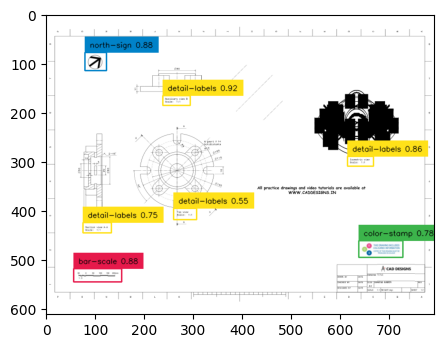

Selected Image ID -  9


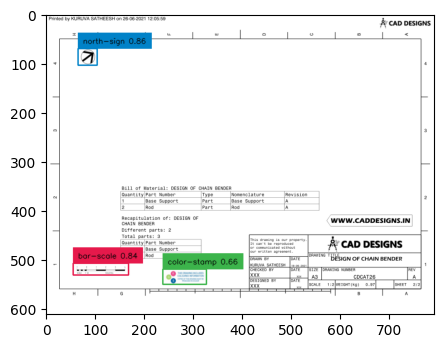

Selected Image ID -  10


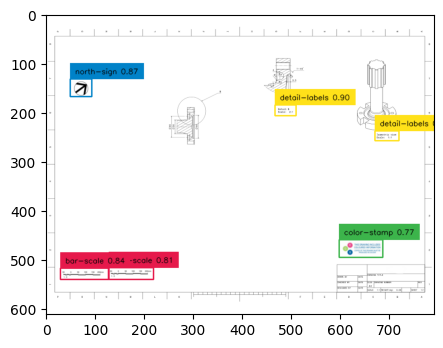

Selected Image ID -  11


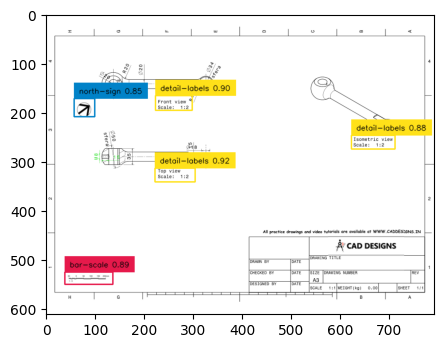

Selected Image ID -  12


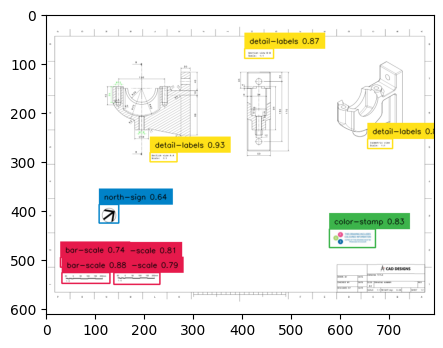

Selected Image ID -  13


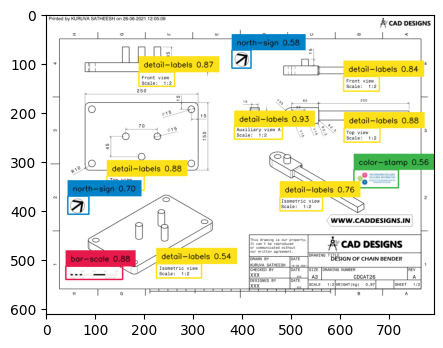

Selected Image ID -  14


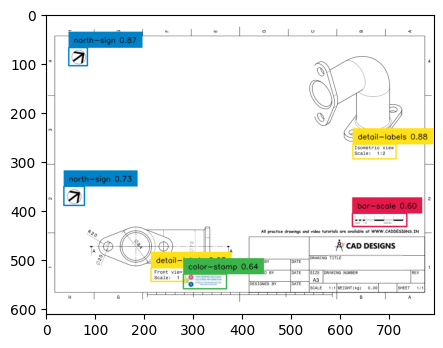

Selected Image ID -  15


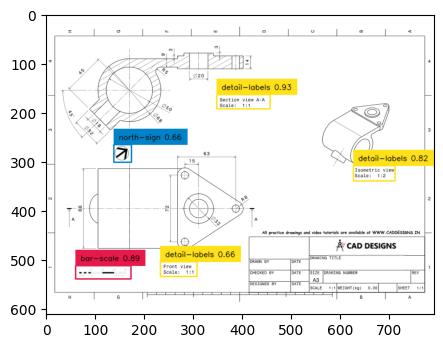

Selected Image ID -  16


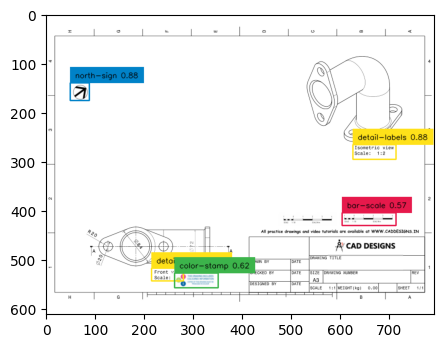

Selected Image ID -  17


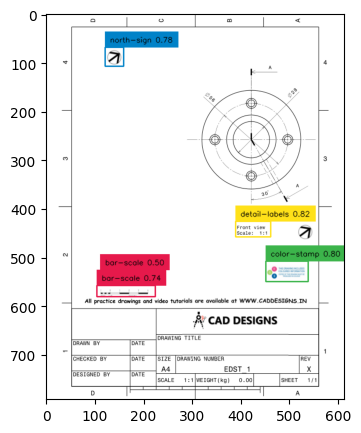

Selected Image ID -  18


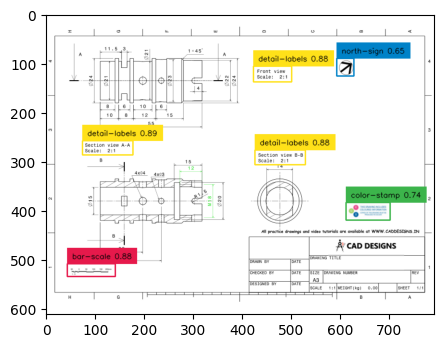

In [ ]:
results = []
for image_id in image_ids:
  result = predict(TEST_DATASET, image_id)
  results.append(result)